### See whether it makes sense to use the ccgp conf weights to assess whether beliefs are organized by dimension or not...

In [8]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io

import scipy
import argparse
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
PAIRS_PATH = "/data/patrick_res/sessions/both/pairs_at_least_3blocks_10sess.pickle"

pairs = pd.read_pickle(PAIRS_PATH).reset_index(drop=True)

In [15]:
def get_sims(args):
    all_res = []
    for i, pair in pairs.iterrows():
        feat_x, feat_y = pair.pair
        args.feat_pair = pair.pair

        args.feat = feat_x
        weights_x = belief_partitions_io.get_weights(args)
        args.feat = feat_y
        weights_y = belief_partitions_io.get_weights(args)

        merged = pd.merge(weights_x, weights_y, on=["PseudoUnitID", "TimeIdx"], suffixes=("_x", "_y"), how="outer").fillna(0)
        sims = merged.groupby(["TimeIdx"]).apply(lambda x: classifier_utils.cosine_sim(x.weightsdiff_normed_x, x.weightsdiff_normed_y)).reset_index(name="cosine_sim")
        sims["dim_type"] = pair.dim_type
        sims["pair_str"] = "_".join(pair.pair)
        all_res.append(sims)
    all_res = pd.concat(all_res) 
    return all_res

def compute_diff(sim_res):
    within_res = sim_res[sim_res.dim_type == "within dim"]
    across_res = sim_res[sim_res.dim_type == "across dim"]
    merged = pd.merge(within_res, across_res, how="cross", suffixes=("_within", "_across"))
    return pd.DataFrame({"TimeIdx": sim_res.name, "diff": merged["cosine_sim_within"] - merged["cosine_sim_across"]})


In [18]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "both"
args.mode = "feat_belief"
args.base_output_path = "/data/patrick_res/ccgp_conf"
args.sig_unit_level = "pref_conf_99th_window_filter_drift"

sim = get_sims(args)
diffs = sim.groupby("TimeIdx").apply(compute_diff).reset_index(drop=True)

shuffle_diffs = []
for i in range(10):
    args.shuffle_idx = i
    try: 
        sim = get_sims(args)
        diffs = sim.groupby("TimeIdx").apply(compute_diff).reset_index(drop=True)
        shuffle_diffs.append(diffs)
    except FileNotFoundError:
        print("not found for shuff")
shuffle_diffs = pd.concat(shuffle_diffs)
diffs["shuffle_type"] = "true"
shuffle_diffs["shuffle_type"] = "shuffle"
all_diffs = pd.concat((diffs, shuffle_diffs))
all_diffs["Time"] = all_diffs["TimeIdx"] / 10

not found for shuff
not found for shuff
not found for shuff


In [20]:
all_diffs = all_diffs[all_diffs.Time < 0]

In [21]:
all_diffs

,TimeIdx,diff,shuffle_type,Time
0,-9,-0.114073,true,-0.9
1,-9,0.250493,true,-0.9
2,-9,-0.148030,true,-0.9
3,-9,-0.204359,true,-0.9
4,-9,-0.405057,true,-0.9
...,...,...,...,...
1723,-1,-0.079292,shuffle,-0.1
1724,-1,-0.126703,shuffle,-0.1
1725,-1,-0.688868,shuffle,-0.1
1726,-1,-0.032885,shuffle,-0.1


0.44381448707201054


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='shuffle_type', ylabel='diff'>)

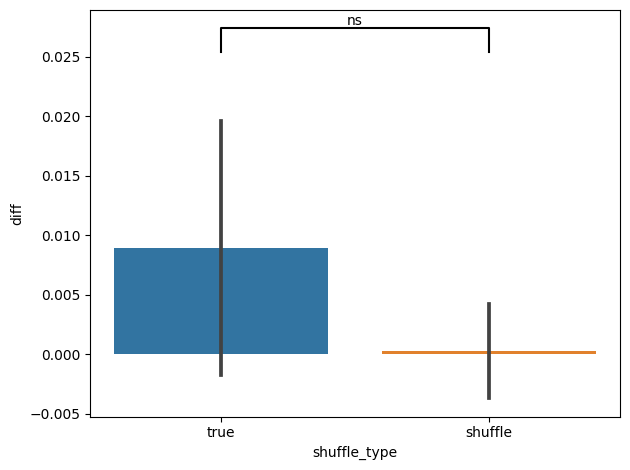

In [25]:
fig, ax = plt.subplots()
sns.barplot(all_diffs, x="shuffle_type", y="diff", errorbar="se", ax=ax)
visualization_utils.add_significance_bars(fig, ax, all_diffs, "shuffle_type", "diff")